<a href="https://colab.research.google.com/github/Annie-Yeeun-Jang/Plant_disease_classification/blob/master/DenseNet_no_freeze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import necessary packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D, Activation, Dropout, Dense
from keras.optimizers import Adam
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
dst_path = '/content/gdrive/My Drive/dataset_split_aug'
# 경로 지정
import os
os.chdir('/content/gdrive/My Drive/dataset_split_aug')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### 이미지 노이즈

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join(dst_path, 'train')
validation_dir = os.path.join(dst_path, 'validation')
test_dir = os.path.join(dst_path, 'test')

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   zoom_range=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(64,64),
                                                    batch_size=64,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(64,64),
                                                        batch_size=64,
                                                        class_mode='categorical')

Found 30748 images belonging to 33 classes.
Found 7989 images belonging to 33 classes.


### DenseNet 모델 구성

In [ ]:
SIZE=64
N_ch=3

In [ ]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(33,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    #model.summary()
    return model

### 모델 실행

In [ ]:
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)

MODEL_SAVE_FOLDER_PATH='/content/gdrive/My Drive/model_save/dense/'
model_path = MODEL_SAVE_FOLDER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'

checkpoint= ModelCheckpoint(filepath=model_path,monitor='val_accuracy',verbose=1, save_best_only=True)
earlystop=EarlyStopping(patience=10)

my_callbacks = [earlystop,checkpoint,annealer]

In [ ]:
model = build_densenet()
model.summary()

29089792/29084464 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Model)          multiple                  7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
____________________________________________________________

In [ ]:
dense = model.fit_generator(train_generator,
                            epochs=50,
                            validation_data=validation_generator,
                            callbacks=my_callbacks)

Epoch 1/50
480/481 [============================>.] - ETA: 17s - loss: 3.1499 - accuracy: 0.2611

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 27 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 95 could not be retrieved. It could be because a worker has died.
  UserWarning)


481/481 [==============================] - 10271s 21s/step - loss: 3.1464 - accuracy: 0.2618 - val_loss: 1.6667 - val_accuracy: 0.5570

Epoch 00001: val_accuracy improved from -inf to 0.55702, saving model to /content/gdrive/My Drive/model_save/dense/01-1.6667.hdf5
Epoch 2/50
481/481 [==============================] - 127s 263ms/step - loss: 1.2564 - accuracy: 0.6383 - val_loss: 0.6380 - val_accuracy: 0.7802

Epoch 00002: val_accuracy improved from 0.55702 to 0.78020, saving model to /content/gdrive/My Drive/model_save/dense/02-0.6380.hdf5
Epoch 3/50
481/481 [==============================] - 120s 250ms/step - loss: 0.7660 - accuracy: 0.7707 - val_loss: 0.6235 - val_accuracy: 0.8025

Epoch 00003: val_accuracy improved from 0.78020 to 0.80248, saving model to /content/gdrive/My Drive/model_save/dense/03-0.6235.hdf5
Epoch 4/50
481/481 [==============================] - 120s 249ms/step - loss: 0.5597 - accuracy: 0.8282 - val_loss: 0.3235 - val_accuracy: 0.8477

Epoch 00004: val_accuracy i

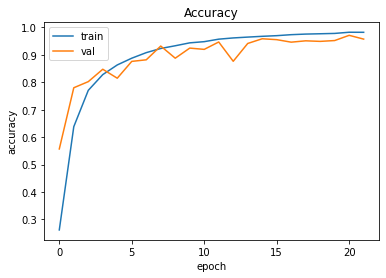

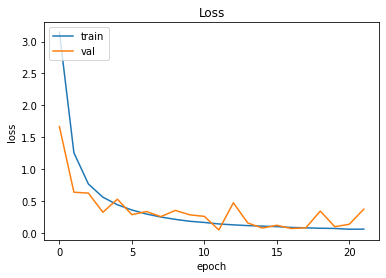

In [ ]:
# accuracy plot 
plt.plot(dense.history['accuracy'])
plt.plot(dense.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# loss plot
plt.plot(dense.history['loss'])
plt.plot(dense.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.save('/content/gdrive/My Drive/model_save/dense/DenseNet.h5')

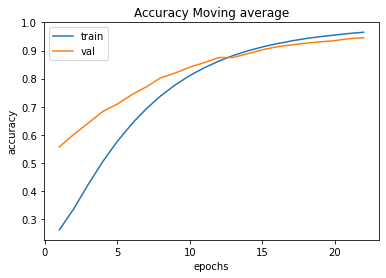

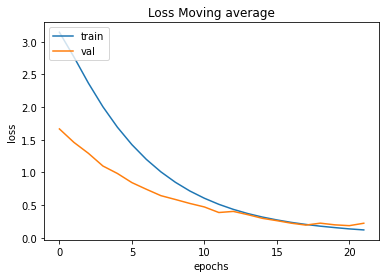

In [ ]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history_train = smooth_curve(dense.history['accuracy'])
smooth_mae_history_val = smooth_curve(dense.history['val_accuracy'])
plt.plot(range(1, len(smooth_mae_history_train) + 1), smooth_mae_history_train)
plt.plot(range(1, len(smooth_mae_history_val) + 1), smooth_mae_history_val)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy Moving average')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


plt.plot(smooth_curve(dense.history['loss']))
plt.plot(smooth_curve(dense.history['val_loss']))
plt.title('Loss Moving average')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()